# Kaggle Titanic Challenge

Here is a link to the dataset: https://www.kaggle.com/c/titanic.

## Goal
Apply machine learning to predict which passengers survived the Titanic sinking. 

**My goal is to submit a trained model and try to go up the leaderboard.** 

## Overview
**training set: train.csv**

*Shape*: (891, 12)

**testing set: test.csv**

*Shape*: (418, 11)

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
params = {
    'axes.labelsize': 'large',
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25,7]
}
plt.rcParams.update(params)

In [4]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Data Cleaning

First, I will impute the missing values. Then, proceed to pre-processing the data and feature engineering.

--- 

*Survived* is the label I want to predict. 0 means the passenger died, while 1 means they lived.

*PassengerId* will not be used in training, and so can be dropped.

### Imputing the Missing Values - Training

In [7]:
n_missing = train.isnull().sum().sort_values(ascending=False)
percent_missing = train.isnull().sum().sort_values(ascending=False) / len(train)
missing_train = pd.DataFrame(data=[n_missing, percent_missing])
missing_train

,Cabin,Age,Embarked,Fare,Ticket,Parch,SibSp,Sex,Name,Pclass,Survived,PassengerId
0,687.000000,177.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.771044,0.198653,0.002245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


About 19% of the training data is missing *Age*. About 77% is missing *Cabin*, and 2 observations are missing *Embarked*.

#### Imputing Embarked

In [8]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Impute these two observations with the mode of Embarked. 

In [9]:
train.Embarked.fillna('C', inplace=True)

#### Imputing Cabin

Since ~77% of the features are missing, one may consider dropping it. But, having no data on *Cabin* can represent the passenger's low socio-economic status, which may be a factor towards their survival. As such, it is better to impute them.

The observations missing *Cabin* will be imputed with 'N'.
All others will be imputed with the first letter of the *Cabin* variable. 

In [10]:
train.Cabin.fillna('N', inplace=True)

In [11]:
train.Cabin.unique()

array(['N', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [12]:
train.Cabin = [i[0] for i in train.Cabin]

In [13]:
train.Cabin.value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

#### Imputing Age

About 20% of the training observations are missing *Age*. To impute these, I will use Linear Regression to predict these missing values. 

However, this will be done once I engineer more features.

### Imputing the Missing Values - Testing

In [14]:
n_missing = test.isnull().sum().sort_values(ascending=False)
percent_missing = test.isnull().sum().sort_values(ascending=False) / len(train)
missing_test = pd.DataFrame(data=[n_missing, percent_missing])
missing_test

,Cabin,Age,Fare,Embarked,Ticket,Parch,SibSp,Sex,Name,Pclass,PassengerId
0,327.000000,86.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.367003,0.096521,0.001122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


86 of the testing data is missing *Age*. About 36% is missing *Cabin*, and 1 observation is missing *Fare*.

#### Imputing Fare

In [15]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Impute this observation with the mean of passengers who are 'male', *Pclass* of '3', and *Embarked* from 'S'. 

In [16]:
miss_val = test.loc[(test.Sex == 'male') & (test.Pclass == 3) & (test.Embarked == 'S')].Fare.mean()
test.Fare.fillna(miss_val, inplace=True)

#### Imputing Cabin

Perform the same imputation done to the training set to be consistent.

In [17]:
test.Cabin.fillna('N', inplace=True)

In [18]:
test.Cabin.unique()

array(['N', 'B45', 'E31', 'B57 B59 B63 B66', 'B36', 'A21', 'C78', 'D34',
       'D19', 'A9', 'D15', 'C31', 'C23 C25 C27', 'F G63', 'B61', 'C53',
       'D43', 'C130', 'C132', 'C101', 'C55 C57', 'B71', 'C46', 'C116',
       'F', 'A29', 'G6', 'C6', 'C28', 'C51', 'E46', 'C54', 'C97', 'D22',
       'B10', 'F4', 'E45', 'E52', 'D30', 'B58 B60', 'E34', 'C62 C64',
       'A11', 'B11', 'C80', 'F33', 'C85', 'D37', 'C86', 'D21', 'C89',
       'F E46', 'A34', 'D', 'B26', 'C22 C26', 'B69', 'C32', 'B78',
       'F E57', 'F2', 'A18', 'C106', 'B51 B53 B55', 'D10 D12', 'E60',
       'E50', 'E39 E41', 'B52 B54 B56', 'C39', 'B24', 'D28', 'B41', 'C7',
       'D40', 'D38', 'C105'], dtype=object)

In [19]:
test.Cabin = [i[0] for i in test.Cabin]

In [20]:
test.Cabin.value_counts()

N    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin, dtype: int64

In the training set, there is a *Cabin* with the label 'T'. When this is one-hot encoded, I will drop this column from the training set. Keeping it can cause some complications for training the model. 

If the model is trained on features that do not exist in the testing set, then the model can overfit the training set, and cannot generalize to new data. The model will have more variance and less bias.

#### Imputing Age

86 of the testing observations are missing *Age*. To impute these, I will use Linear Regression to predict these missing values. 

However, this will be done once I engineer more features.

### Feature Extraction

*Name* - Extract the title of each passenger. A passenger's title can have an effect on whether or not they survived. For instance, those with the title of *Master* may have been given priority to get on a life boat.

*SibSp* and *Parch* - Can create new features called *NumFamily*. So, for each passenger, the values of *SibSp* and *Parch* will be added + 1 (representing the passenger him/herself). 

*Ticket* - More analysis needs to be done for this feature. 

#### Extracting Title from Name

In [21]:
def get_title(i):
    title = i.split(', ')[1].split('.')[0]
    return title

In [22]:
train['Title'] = train.Name.apply(get_title)
test['Title'] = test.Name.apply(get_title)

In [23]:
title_dict = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Ms': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Dr',
    'Rev': 'Rev',
    'Col': 'Officer',
    'Mlle': 'Miss',
    'Major': 'Officer',
    'the Countess': 'Royal',
    'Sir': 'Royal',
    'Capt': 'Officer',
    'Don': 'Royal',
    'Mme': 'Royal',
    'Jonkheer': 'Royal',
    'Lady': 'Royal',
    'Dona': 'Royal'
}

train.Title = train.Title.map(title_dict)
train.drop('Name', axis=1, inplace=True)
test.Title = test.Title.map(title_dict)
test.drop('Name', axis=1, inplace=True)

In [24]:
train.Title.value_counts()

Mr         517
Miss       185
Mrs        125
Master      40
Dr           7
Rev          6
Royal        6
Officer      5
Name: Title, dtype: int64

In [25]:
test.Title.value_counts()

Mr         240
Miss        79
Mrs         72
Master      21
Rev          2
Officer      2
Dr           1
Royal        1
Name: Title, dtype: int64

#### Engineering NumFamily

In [26]:
train['NumFamily'] = train.SibSp + train.Parch + 1
test['NumFamily'] = test.SibSp + test.Parch + 1

#### Analyzing Ticket

In [27]:
train.Ticket.value_counts()

347082              7
CA. 2343            7
1601                7
CA 2144             6
3101295             6
347088              6
382652              5
S.O.C. 14879        5
2666                4
347077              4
113760              4
LINE                4
349909              4
19950               4
113781              4
PC 17757            4
17421               4
4133                4
W./C. 6608          4
PC 17582            3
24160               3
SC/Paris 2123       3
13502               3
345773              3
110152              3
239853              3
29106               3
F.C.C. 13529        3
363291              3
347742              3
                   ..
2628                1
C.A. 34260          1
28134               1
315151              1
3101267             1
236171              1
234818              1
239854              1
17466               1
A/4 45380           1
364851              1
244270              1
STON/O2. 3101290    1
PC 17476            1
237798    

Looking at the unique values, there does not seem to be any reasonable way to distinguish/ clear up the data. There are lots of different levels for *Ticket*, and there is no clear way of pre-processing it. 

One may argue that *Ticket* can represent the socio-economic status of a passenger, which can influence survival. However, this can already be explained by the *Fare*, which is a much more interpretable way of determining the socio-economic status of a passenger.

So, I will drop *Ticket* from both datasets.

In [28]:
train.drop('Ticket', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)

### Pre-processing

*Pclass* - This is an integer, but is really describing is the social class the passenger belongs in (1st, 2nd, 3rd). One-Hot Encode for each social class level.

*Cabin*, *Embarked*, *Sex* - One-hot encode this. 

*Age* - Use Linear Regression to determine the missing *Age* values.

*PassengerId* - Drop this, since we won't need this in training. 

---

After imputing *Age*, drop *Cabin_T* from the training set. 

In [29]:
train.drop('PassengerId', axis=1, inplace=True)

In [30]:
train = pd.get_dummies(train, columns=['Title','Pclass','Embarked', 'Sex', 'Cabin'])
test = pd.get_dummies(test, columns=['Title','Pclass','Embarked', 'Sex', 'Cabin'])

In [31]:
train.drop('Cabin_T', axis=1, inplace=True)

#### Imputing Age Via Logistic Regression

In [32]:
def impute_age(df):
    temp_test = df.loc[df.Age.isnull()]
    temp_train = df.loc[df.Age.notna()]

    temp_train_X = temp_train.loc[:, 'SibSp':]
    temp_test_X = temp_test.loc[: , 'SibSp':]
    temp_train_y = temp_train.Age
    temp_test_y = temp_test.Age

    logreg = LinearRegression().fit(temp_train_X, temp_train_y)
    preds = logreg.predict(temp_test_X)

    df.loc[df.Age.isnull(), 'Age'] = preds

In [33]:
impute_age(train)
impute_age(test)

## Data Analysis

**After Feature Extraction and Pre-Processing...**

train - Shape: (891,31)

test - Shape: (418, 30)

### Heat-map of the correlation of Top 10 Features on Survived

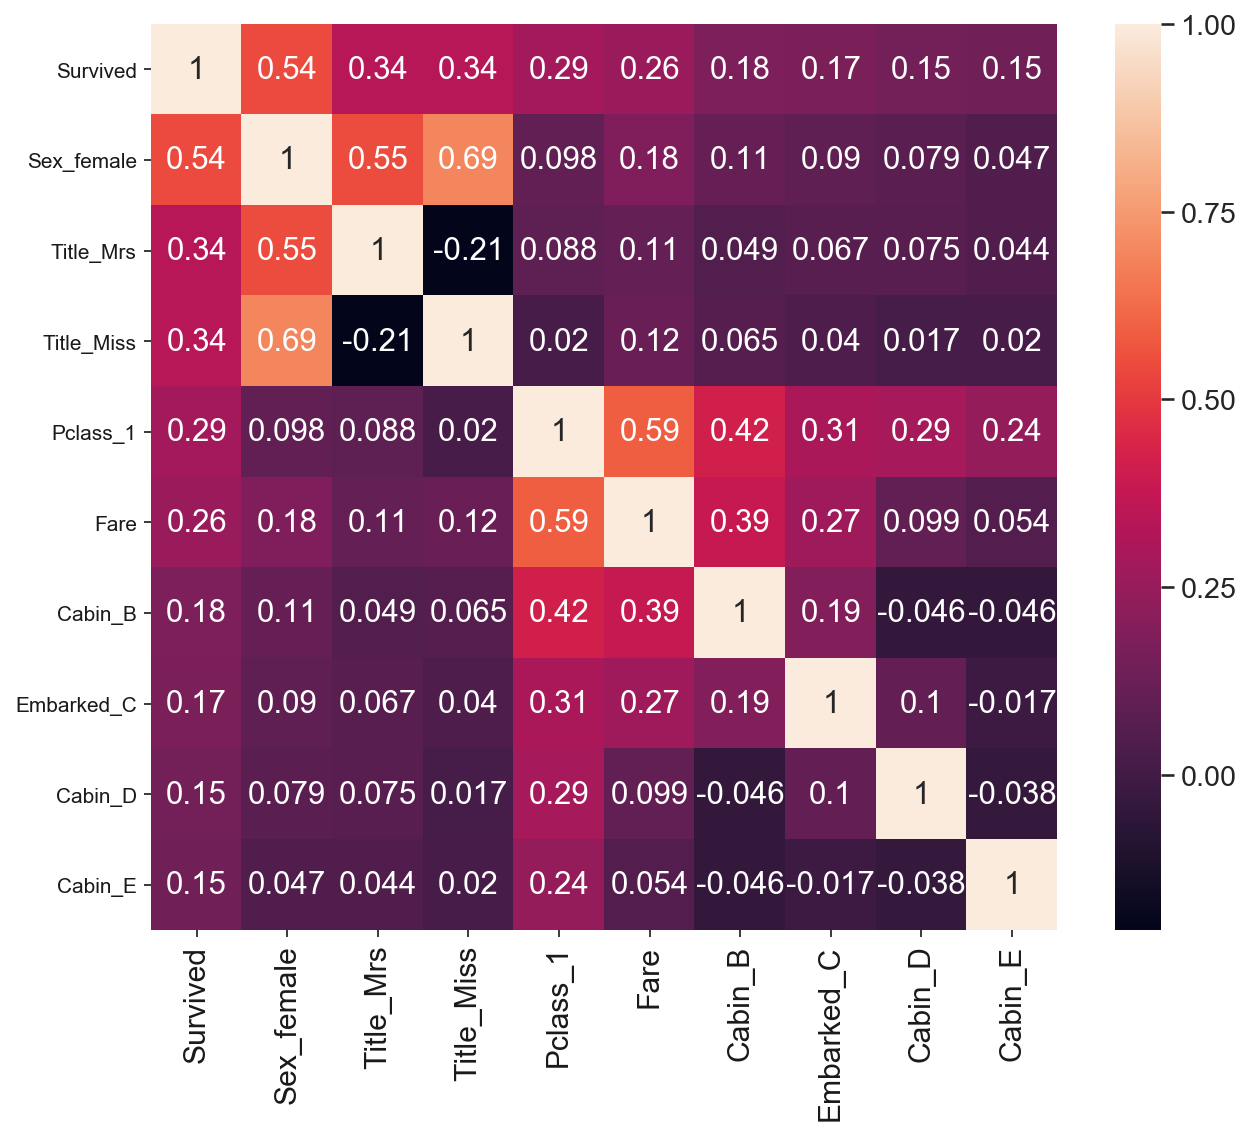

In [34]:
correlation_mat = train.corr(method='pearson')
corr_cols = correlation_mat.nlargest(10, 'Survived')['Survived'].index
correlation_mat = np.corrcoef(train[corr_cols].values.transpose())
f, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.25)
sns.heatmap(correlation_mat, square=True, annot=True, 
            yticklabels=corr_cols.values, xticklabels=corr_cols.values)
plt.show()

Being a female was correlated relatively strongly with survival, which is also shown in that *Title_Mrs* is also highly correlated with *Survival*.

### Distribution of Survival

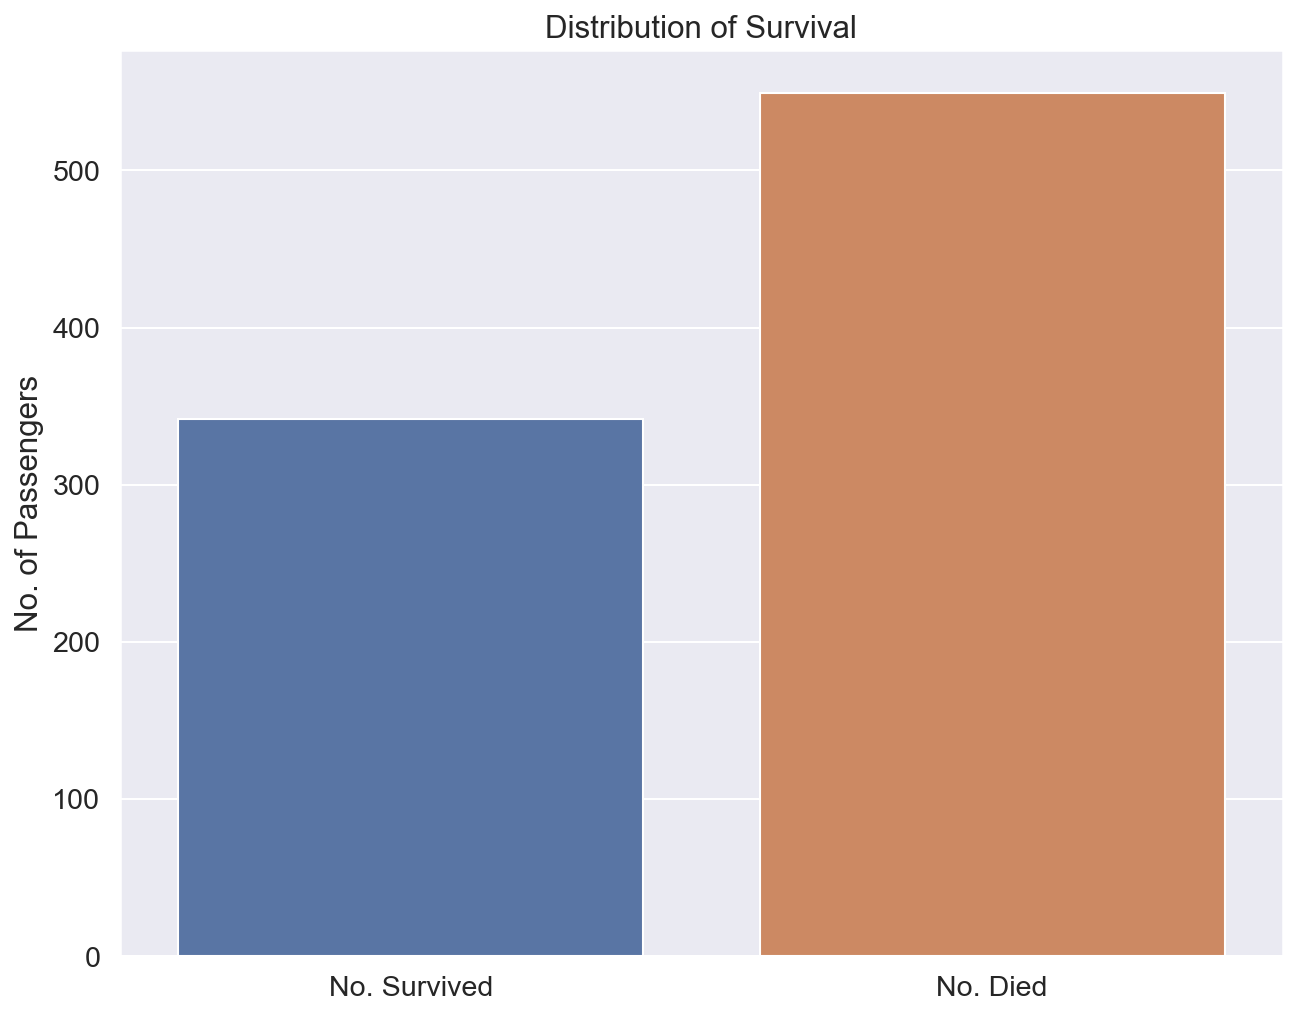

In [35]:
n_survived = len(train.loc[train["Survived"] == 1])
n_died = len(train) - n_survived

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['No. Survived', 'No. Died'], y=[n_survived, n_died]) 
plt.title('Distribution of Survival')
plt.ylabel('No. of Passengers')
plt.show()

Above, we see the distribution of all passengers that survived and died on the Titanic. As we can see, there are more casualties than survivors in the training set. This imbalance of classes would mean that, instead of using the accuracy as an error metric, it would be more appropriate to use another metric. 

I will use the F-Score as an error metric for training my models on this dataset.

### Distribution of Survival on Gender

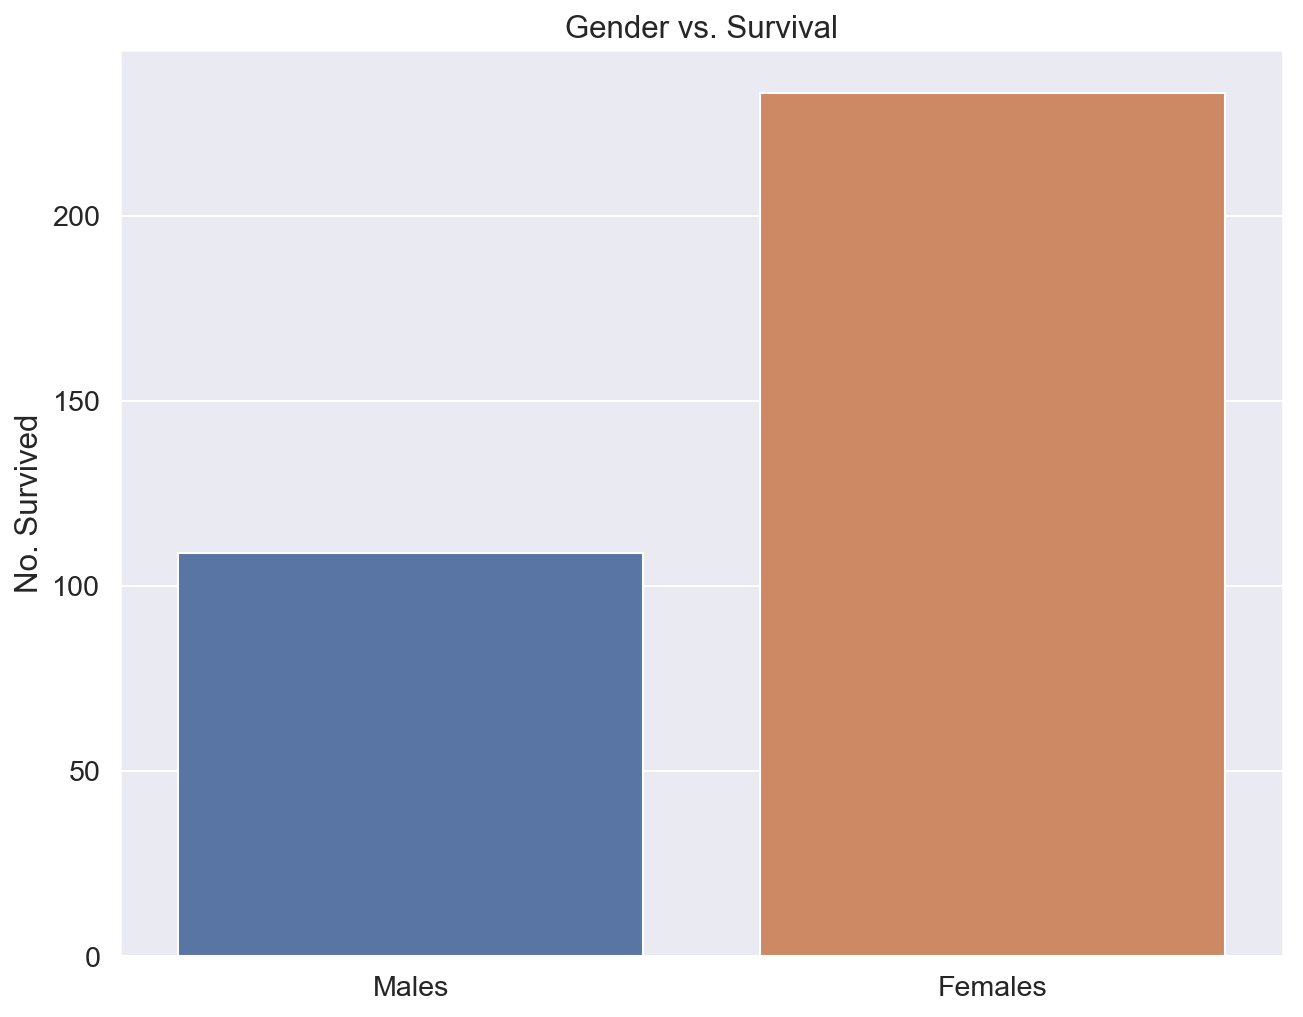

In [36]:
n_females_survived = train[(train['Sex_female'] == 1) & (train['Survived'] == 1)].Sex_female.sum()

n_males_survived = train[(train['Sex_male'] == 1) & (train['Survived'] == 1)].Sex_male.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['Males', 'Females'], y=[n_males_survived, n_females_survived]) 
plt.title('Gender vs. Survival')
plt.ylabel('No. Survived')
plt.show()

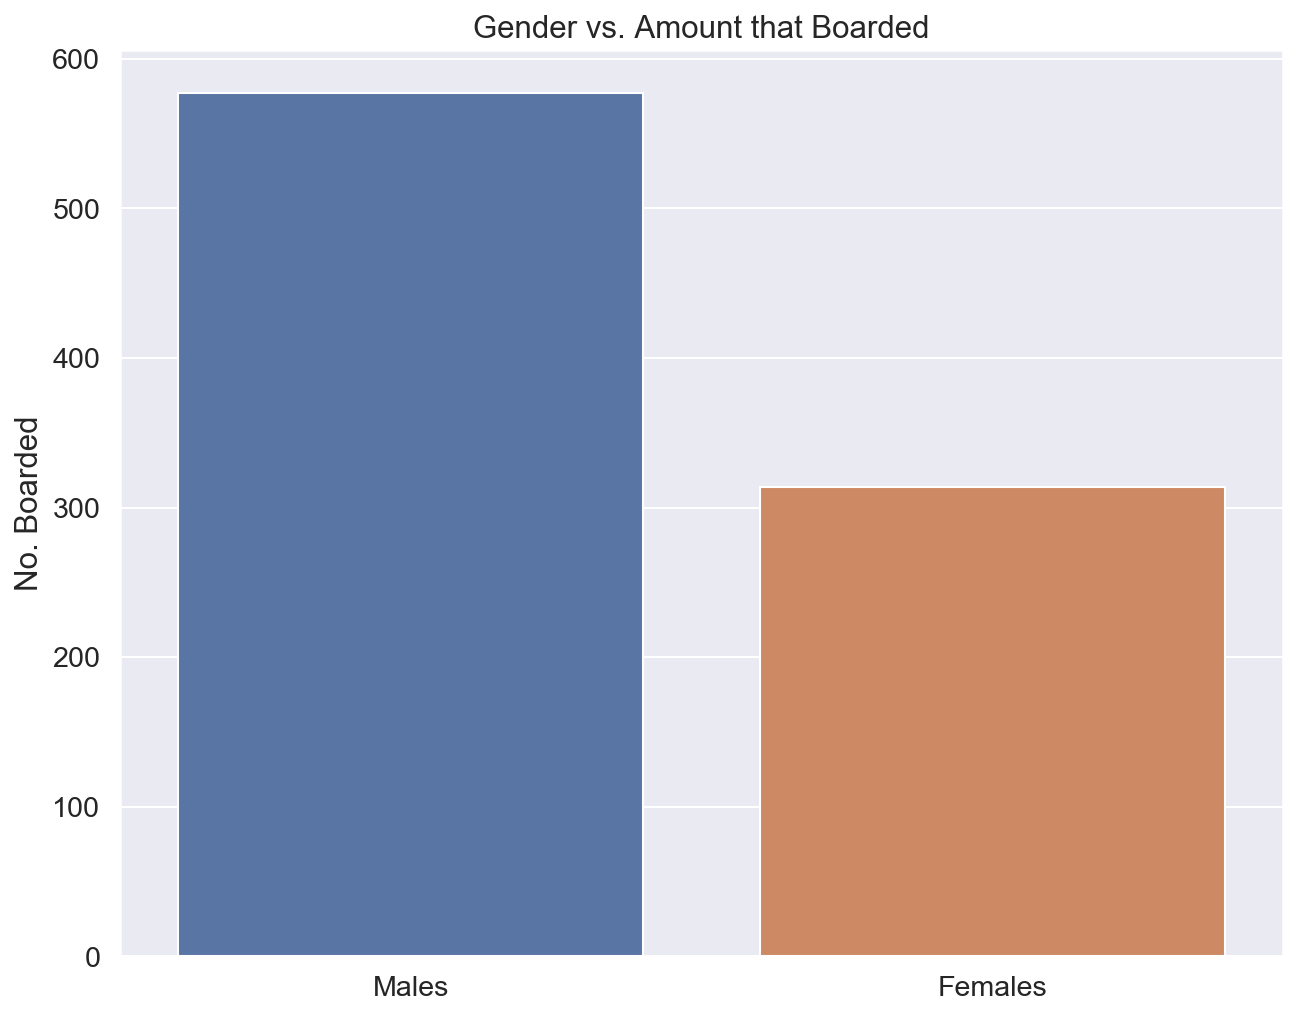

In [37]:
n_total_females = train[(train['Sex_female'] == 1)].Sex_female.sum()
n_total_males = train[(train['Sex_male'] == 1)].Sex_male.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['Males', 'Females'], y=[n_total_males, n_total_females]) 
plt.title('Gender vs. Amount that Boarded')
plt.ylabel('No. Boarded')
plt.show()

In [38]:
print('Proportion of Males that Survived: ', n_males_survived / n_total_males)
print('Proportion of Females that Survived: ', n_females_survived / n_total_females)

Proportion of Males that Survived:  0.18890814558058924
Proportion of Females that Survived:  0.7420382165605095


From the above plots, it would seem that women had a higher chance of surviving the Titanic disaster. Less woman boarded the ship initially, and were given more priority for boarding the lifeboats. 

Above, we can see the proportion of males and females that survived of all males and females, respectively. The proportion of females who survived is almost **4 times** than the proportion of males. 

### Distribution of Survival on Pclass

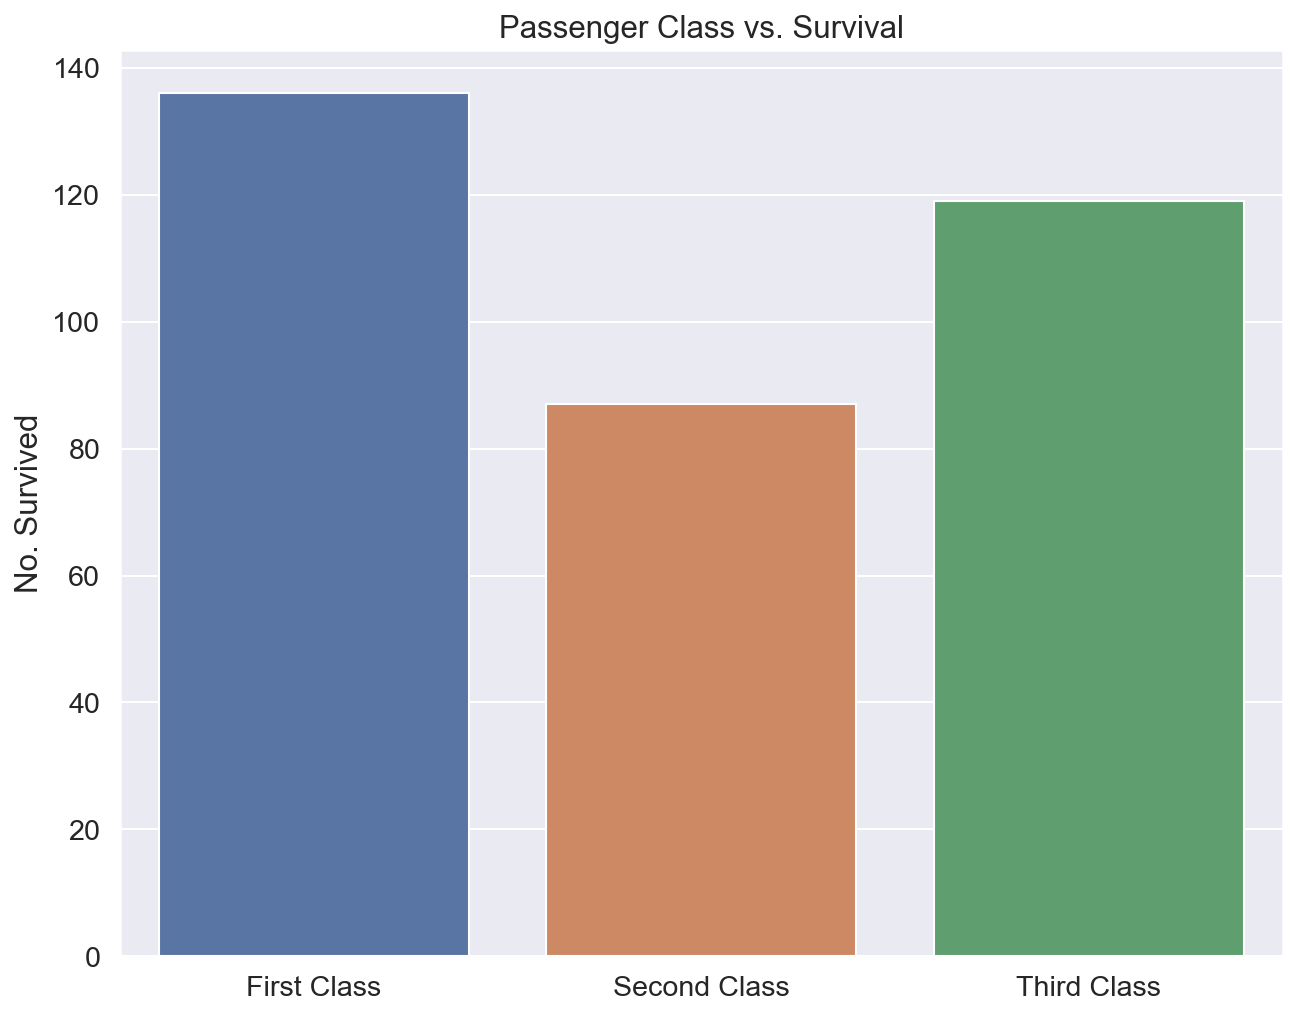

In [39]:
n_firstclass_survived = train[(train['Pclass_1'] == 1) & (train['Survived'] == 1)].Pclass_1.sum()
n_secondclass_survived = train[(train['Pclass_2'] == 1) & (train['Survived'] == 1)].Pclass_2.sum()
n_thirdclass_survived = train[(train['Pclass_3'] == 1) & (train['Survived'] == 1)].Pclass_3.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['First Class', 'Second Class', 'Third Class'], 
            y=[n_firstclass_survived, n_secondclass_survived, n_thirdclass_survived]) 
plt.title('Passenger Class vs. Survival')
plt.ylabel('No. Survived')
plt.show()

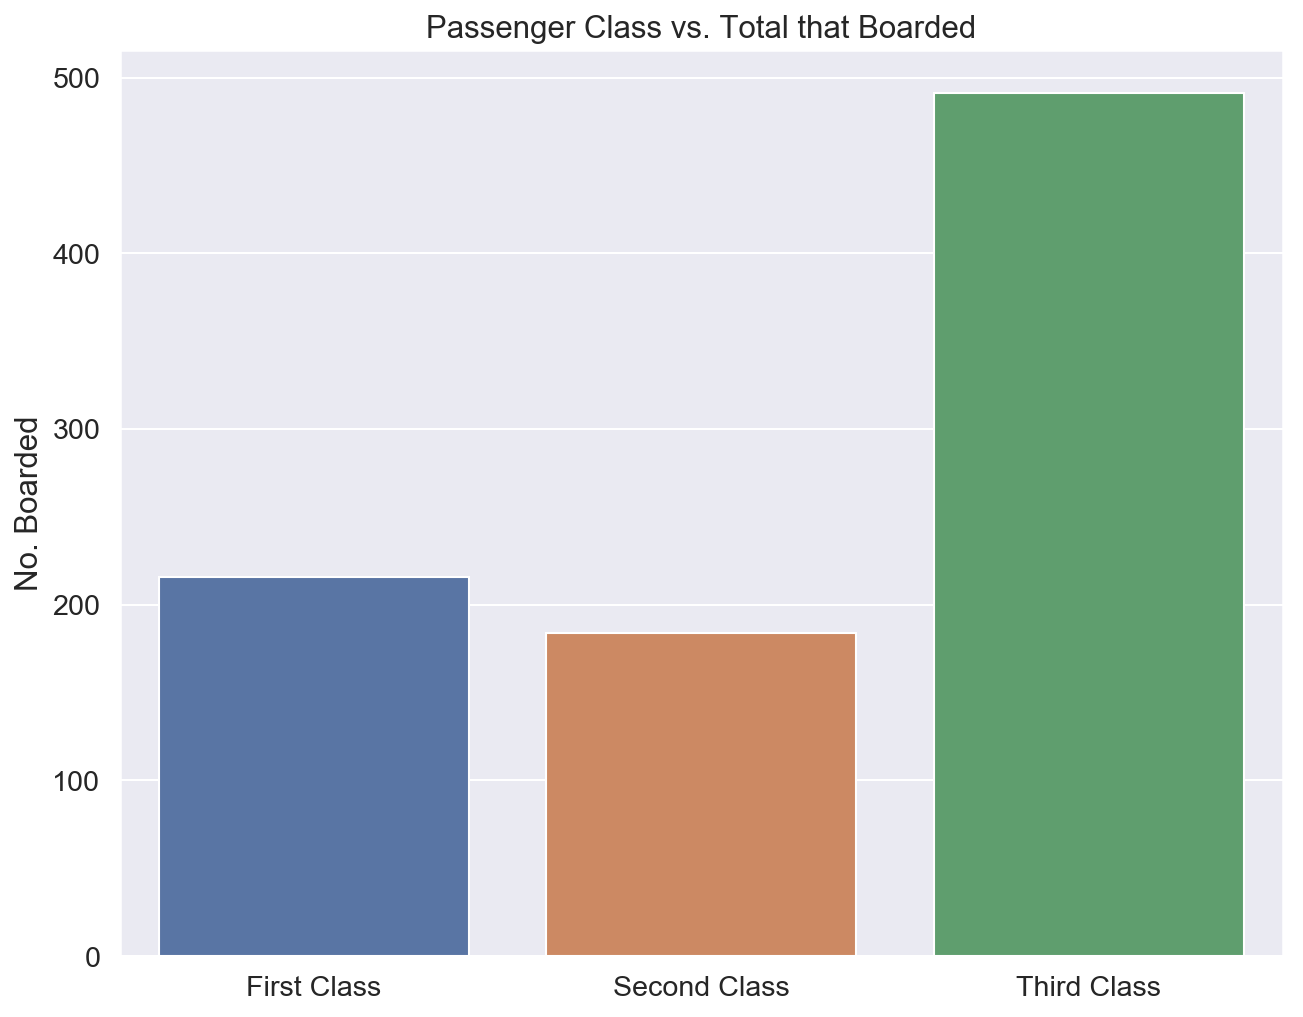

In [40]:
n_firstclass_total = train[(train['Pclass_1'] == 1)].Pclass_1.sum()
n_secondclass_total = train[(train['Pclass_2'] == 1)].Pclass_2.sum()
n_thirdclass_total = train[(train['Pclass_3'] == 1)].Pclass_3.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['First Class', 'Second Class', 'Third Class'], 
            y=[n_firstclass_total, n_secondclass_total, n_thirdclass_total]) 
plt.title('Passenger Class vs. Total that Boarded')
plt.ylabel('No. Boarded')
plt.show()

In [41]:
print('Proportion of First Class that Survived: ', n_firstclass_survived / n_firstclass_total)
print('Proportion of Second Class that Survived: ', n_secondclass_survived / n_secondclass_total)
print('Proportion of Third Class that Survived: ', n_thirdclass_survived / n_thirdclass_total)

Proportion of First Class that Survived:  0.6296296296296297
Proportion of Second Class that Survived:  0.47282608695652173
Proportion of Third Class that Survived:  0.24236252545824846


Above, we can see several bar charts showing the amount of each *Passenger* class that boarded, and how many of each class survived the disaster. 

Around 62% of all First Class passengers survived the Titanic sinking, which is almost **3 times** than that of Third Class passengers, where only about 24% of the all Third Class passengers survived. 

# Modeling

In [42]:
train.head(3)

,Survived,Age,SibSp,Parch,Fare,NumFamily,Title_Dr,Title_Master,Title_Miss,Title_Mr,...,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N
0,0,22.0,1,0,7.2500,2,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,2,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1,26.0,0,0,7.9250,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


Looking at the above, *Age* and *Fare* are very different from the other quantitative variables. So, I will scale them by standardizing them. 

In [43]:
train.Age = scale(train.Age)
train.Fare = scale(train.Fare)

In [44]:
test.Age = scale(test.Age)
test.Fare = scale(test.Fare)

In [45]:
train.head(3)

,Survived,Age,SibSp,Parch,Fare,NumFamily,Title_Dr,Title_Master,Title_Miss,Title_Mr,...,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N
0,0,-0.562636,1,0,-0.502445,2,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,1,0.608746,1,0,0.786845,2,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1,-0.269791,0,0,-0.488854,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [46]:
train = shuffle(train)
test = shuffle(test)

### Splitting Training Data

In [53]:
X = train.iloc[:, 1:]
y = train.Survived

### Logit Model

In [61]:
import statsmodels.api as sm

logit = sm.Logit(y, sm.add_constant(X))
results = logit.fit(maxiter = 41)
results.summary()

         Current function value: 0.396512
         Iterations: 41


D:\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      866
Method:                           MLE   Df Model:                           24
Date:                Tue, 09 Apr 2019   Pseudo R-squ.:                  0.4046
Time:                        20:41:00   Log-Likelihood:                -353.29
converged:                      False   LL-Null:                       -593.33
                                        LLR p-value:                 2.271e-86
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.4811        nan        nan        nan         nan         nan
Age              -0.4646      0.140     -3.309      0.001      -0.740      -0.189
SibSp             0.5624   1.26e+06   4.47e-07      1.000   -2.46e+06    2.46e+06
Parch             0.7760   1.26e+06   6.17e-07      1.000   -2.46e+06    2.46e+06
Fare              0.2118      0.144      1.468      0.142      -0.071       0.495
NumFamily        -1.1427   1.26e+06  -9.09e-07      1.000   -2.46e+06    2.46e+06
Title_Dr          6.4148        nan        nan        nan         nan         nan
Title_Master      9.1214        nan        nan        nan         nan         nan
Title_Miss      -11.2509        nan        nan        nan         nan         nan
Title_Mr          5.8404        nan        nan        nan         nan         nan
Title_Mrs       -10.3041        nan        nan        nan         nan         nan
Title_Officer     6.7693        nan        nan        nan         nan         nan
Title_Rev       -15.2003        nan        nan        nan         nan         nan
Title_Royal       6.1282        nan        nan        nan         nan         nan
Pclass_1         -0.1599   3.21e+06  -4.98e-08      1.000    -6.3e+06     6.3e+06
Pclass_2         -0.6228   3.21e+06  -1.94e-07      1.000    -6.3e+06     6.3e+06
Pclass_3         -1.6984   3.21e+06  -5.29e-07      1.000    -6.3e+06     6.3e+06
Embarked_C       -0.6706        nan        nan        nan         nan         nan
Embarked_Q       -0.7100        nan        nan        nan         nan         nan
Embarked_S       -1.1005        nan        nan        nan         nan         nan
Sex_female        8.7291        nan        nan        nan         nan         nan
Sex_male        -11.2102        nan        nan        nan         nan         nan
Cabin_A          10.1243    217.124      0.047      0.963    -415.431     435.680
Cabin_B          10.0486    217.124      0.046      0.963    -415.507     435.604
Cabin_C           9.7282    217.124      0.045      0.964    -415.826     435.283
Cabin_D          10.7477    217.124      0.050      0.961    -414.807     436.303
Cabin_E          11.0914    217.124      0.051      0.959    -414.464     436.646
Cabin_F          10.1048    217.126      0.047      0.963    -415.453     435.663
Cabin_G           8.7911    217.126      0.040      0.968    -416.769     434.351
Cabin_N           9.3652    217.124      0.043      0.966    -416.190     434.920
=================================================================================
"""

### PCA

Made submission accuracy worse

In [58]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)
transform_X = pca.transform(X)

In [59]:
X_train_val, X_test, y_train_val, y_test = train_test_split(transform_X, y, test_size=0.2)

### Logistic Regression

In [60]:
C_list = [0.05, 0.01, 0.5, 0.1, 1, 1.5, 2]
logreg_params = {'C': C_list, 'penalty': ['l2']}

logreg = LogisticRegression(solver="lbfgs", max_iter = 200)

logreg_grid = GridSearchCV(logreg, logreg_params, cv=5, scoring='f1')
logreg_grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.05, 0.01, 0.5, 0.1, 1, 1.5, 2], 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [61]:
logreg_grid.best_score_

0.7784191296205829

In [62]:
logreg_grid.best_params_

{'C': 1, 'penalty': 'l2'}

In [63]:
logreg_star = logreg_grid.best_estimator_.fit(X_train_val, y_train_val)
f1 = f1_score(logreg_star.predict(X_test), y_test)

In [65]:
print('Logistic Regression F1 Score: ', f1)

Logistic Regression F1 Score:  0.7559055118110236


### K-Nearest Neighbors

In [66]:
n_neighbors_list=np.arange(1, 11, 1)
knn_params = {'n_neighbors': n_neighbors_list}

knn_grid = KNeighborsClassifier()

knn_grid = GridSearchCV(knn_grid, knn_params, cv=5, scoring='f1')
knn_grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [67]:
knn_grid.best_score_

0.7386482712385597

In [68]:
knn_grid.best_params_

{'n_neighbors': 7}

In [69]:
knn_star = knn_grid.best_estimator_.fit(X_train_val, y_train_val)
f1 = f1_score(knn_star.predict(X_test), y_test)

In [70]:
print('K-Nearest Neighbors F1 Score: ', f1)

K-Nearest Neighbors F1 Score:  0.7500000000000001


### Decision Tree Classifier

In [71]:
criterion_list = ['gini', 'entropy']
max_depth_list = np.arange(2, 11, 1)
min_samples_split_list = np.arange(2, 11, 1)

dt_params = {'criterion': criterion_list, 'max_depth': max_depth_list, 
             'min_samples_split': min_samples_split_list}

dt_grid = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt_grid, dt_params, cv=5, scoring='f1')

dt_grid.fit(X_train_val, y_train_val)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [72]:
dt_grid.best_score_

0.7049116161083633

In [73]:
dt_grid.best_params_

{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 6}

In [74]:
dt_star = dt_grid.best_estimator_.fit(X_train_val, y_train_val)
f1 = f1_score(dt_star.predict(X_test), y_test)

In [75]:
print('Decision Tree Classifier F1 Score: ', f1)

Decision Tree Classifier F1 Score:  0.743801652892562


### Bagging Classifer

In [76]:
n_estimators_list = np.arange(30, 46, 1)
bdt_params = {'n_estimators': n_estimators_list,
              'base_estimator__criterion': criterion_list,
              'base_estimator__max_depth': max_depth_list,
              'base_estimator__min_samples_split': min_samples_split_list}

bc = BaggingClassifier(base_estimator = DecisionTreeClassifier(), 
                       oob_score = True, random_state = 420)
bc_grid = GridSearchCV(estimator = bc, cv=5, param_grid = bdt_params, scoring = 'f1')

bc_grid.fit(X_train_val, y_train_val)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ..._estimators=10, n_jobs=None, oob_score=True,
         random_state=420, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]), 'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'base_estimator__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [77]:
bc_grid.best_score_

0.7584443993389559

In [78]:
bc_grid.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 5,
 'base_estimator__min_samples_split': 8,
 'n_estimators': 38}

In [79]:
bc_star = bc_grid.best_estimator_.fit(X_train_val, y_train_val)
f1 = f1_score(bc_star.predict(X_test), y_test)

In [80]:
print('Bagging Classifier F1 Score: ', f1)

Bagging Classifier F1 Score:  0.7241379310344828


### AdaBoostClassifier

In [81]:
adaboost_clf = AdaBoostClassifier().fit(X_train_val, y_train_val)

In [82]:
f1 = f1_score(adaboost_clf.predict(X_test), y_test)

In [83]:
print('AdaBoostClassifier F1 Score: ', f1)

AdaBoostClassifier F1 Score:  0.7154471544715446


### SVM

In [85]:
C_list = [0.01, 0.1, 1, 1.5, 2, 3]
svc_params={'C': C_list}

svc = SVC(probability=True)

svc = GridSearchCV(svc, svc_params, cv=5, scoring='f1')
svc.fit(X_train_val, y_train_val)

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warnin

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 1.5, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [86]:
svc.best_score_

0.772514831456392

In [87]:
svc.best_params_

{'C': 3}

In [88]:
svc_star = svc.best_estimator_.fit(X_train_val, y_train_val)
f1 = f1_score(svc_star.predict(X_test), y_test)

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [89]:
print('SVM F1 Score: ', f1)

SVM F1 Score:  0.7704918032786885


### VotingClassifier

In [90]:
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg_grid.best_estimator_),
        ('knn', knn_grid.best_estimator_),
        ('dt', dt_grid.best_estimator_),
        ('adaboost', AdaBoostClassifier()),
        ('svc', svc.best_estimator_)
    ], voting='soft').fit(X_train_val, y_train_val)

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [91]:
f1 = f1_score(voting_clf.predict(X_test), y_test)
print('VotingClassifier F1 Score: ', f1)

VotingClassifier F1 Score:  0.7967479674796748


# Submitting Test Predictions

In [92]:
passengerId = test.PassengerId
test.drop('PassengerId', axis=1, inplace=True)
submission = pd.DataFrame({
    'PassengerId': passengerId,
    'Survived': voting_clf.predict(test)
})

In [93]:
submission.to_csv('submissions.csv')